In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

In [2]:
episodes = pd.read_csv('../imdb/data/title.episode.tsv.gz', sep='\t')
ratings = pd.read_csv('../imdb/data/title.ratings.tsv.gz', sep='\t')

In [3]:
raw = episodes.merge(ratings, on='tconst')

In [4]:
cond1 = raw.seasonNumber != '\\N'
cond2 = raw.episodeNumber != '\\N'

filtered = raw[cond1 & cond2].copy()

In [5]:
filtered['info'] = (
    'S' + 
    filtered.seasonNumber + 
    'E' + 
    filtered.episodeNumber
)

In [6]:
columns = [
    'parentTconst', 
    'seasonNumber',
    'episodeNumber'
]

for col in columns[1:]:
    filtered[col] = filtered[col].astype(int)

filtered = filtered.sort_values(by=columns)

In [7]:
aggregations = {
    'averageRating': list,
    'info': list
}

grouped = filtered \
    .groupby('parentTconst') \
    .agg(aggregations) \
    .reset_index()

grouped.averageRating = grouped.averageRating.apply(np.array)

In [8]:
series = grouped[grouped.averageRating.str.len() > 10].copy()

In [9]:
series

,parentTconst,averageRating,info
4,tt0040051,"[4.8, 7.4, 7.6, 5.6, 5.6, 6.6, 6.7, 6.8, 5.0, ...","[S1E3, S1E8, S1E13, S1E15, S1E19, S2E6, S2E10,..."
5,tt0040053,"[6.8, 6.4, 5.6, 6.3, 1.2, 6.5, 4.2, 6.7, 7.6, ...","[S5E6, S5E38, S6E36, S8E22, S8E35, S8E40, S9E2..."
9,tt0041024,"[7.6, 7.2, 6.9, 6.8, 7.2, 6.8, 7.4, 6.5, 8.0, ...","[S1E1, S1E4, S1E13, S1E18, S1E19, S1E25, S2E22..."
10,tt0041030,"[7.6, 7.9, 7.3, 7.4, 7.6, 7.1, 7.4, 7.5, 7.5, ...","[S1E1, S1E2, S1E3, S1E4, S1E5, S1E8, S1E9, S1E..."
11,tt0041036,"[6.8, 6.9, 6.2, 5.4, 6.4, 5.8, 6.3, 6.6, 7.2, ...","[S1E1, S1E2, S1E3, S1E4, S1E5, S1E6, S1E7, S1E..."
...,...,...,...
21599,tt9886006,"[7.3, 8.0, 7.9, 7.6, 8.5, 7.5, 7.6, 7.9, 8.0, ...","[S1E1, S1E2, S1E3, S1E4, S1E5, S1E6, S1E7, S1E..."
21600,tt9886950,"[8.7, 8.4, 8.1, 8.1, 8.1, 7.8, 7.6, 7.6, 8.1, ...","[S1E1, S1E2, S1E3, S1E4, S1E5, S1E6, S1E7, S1E..."
21606,tt9899340,"[7.7, 7.7, 7.9, 8.2, 8.2, 8.2, 8.3, 8.3, 8.2, ...","[S1E1, S1E2, S1E3, S1E4, S1E5, S1E6, S1E7, S1E..."
21613,tt9909248,"[6.5, 7.5, 7.2, 6.9, 7.1, 7.1, 7.2, 6.7, 6.5, ...","[S1E0, S1E1, S1E2, S1E3, S1E4, S1E5, S1E6, S2E..."


In [10]:
def plot_data(tid):
    cond = series.parentTconst == tid
    data = series[cond].averageRating.iloc[0]
    trend_or_break = find_breakpoints(data)
    
    if isinstance(trend_or_break, str):
        plt.title(f'Trend: {trend_or_break.title()}')
    else:
        for index, val in trend_or_break:
            plt.axvline(
                index, 
                color='orange', 
                linestyle='dashed'
            )
    
    plt.plot(
        data,
        marker='x',
        color='lightgreen'
    )
        
    plt.show()

In [11]:
def find_breakpoints(data):
    differences = []
    breakpoints = []
    trends = []
    trend = None
    
    if len(np.unique(data)) == 1:
        return breakpoints

    for i, episode in enumerate(data):
        if i == 0 or i + 1 == len(data):
            continue

        # ma: moving average
        ma = np.mean(data[:i])
        
        # nma: ma of next episodes
        nma = np.mean(data[i + 1:])

        # dma: ma of differences
        dma = np.mean(differences) if len(differences) > 0 else 0

        ld = abs(data[i] - data[i - 1])
        differences.append(ld)
        
        if i < 5 or i > len(data) - 5:
            continue
            
        cond1 = data[i] > ma + dma
        cond2 = nma > ma + 3 * dma
        cond3 = data[i] < ma - dma
        cond4 = nma < ma - 3 * dma
        cond5 = ld > dma
        cond6 = trend != 'positive'
        cond7 = trend != 'negative'
        
        if cond1 and cond5:
            trends.append('positive')
        elif cond3 and cond5:
            trends.append('negative')

        if  cond1 and cond2 and cond6:
            trend = 'positive'
        elif  cond3 and cond4 and cond7:
            trend = 'negative'
        else:
            continue

        breakpoints.append((i - 1, trend))
    
    if len(np.unique(trends)) == 1:
        return np.unique(trends)[0]
    
    return breakpoints if len(breakpoints) > 0 else 'stable'

#### Stranger Things
<img src="../img/stranger_things.jpg" align="left" />
<img src="../img/stranger_things.jpg" style="float: left;transform:rotate(180deg);" />

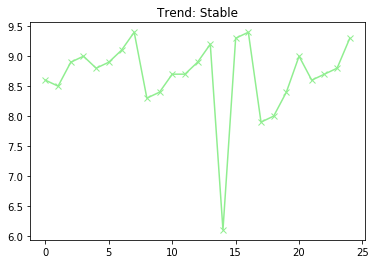

In [12]:
plot_data(tid='tt4574334')

#### Dark
<img src="../img/dark.jpg" align="left" />
<img src="../img/dark.jpg" align="left" />

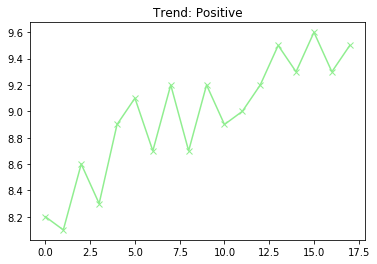

In [13]:
plot_data(tid='tt5753856')

#### Game of Thrones
<img src="../img/got.jpg" align="left" />

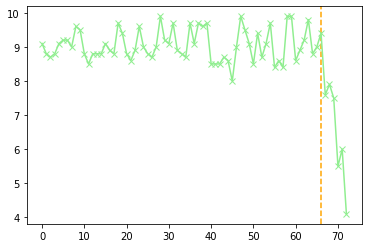

In [14]:
plot_data(tid='tt0944947')

#### True Detective
<img src="../img/true_detective.jpg" align="left" />

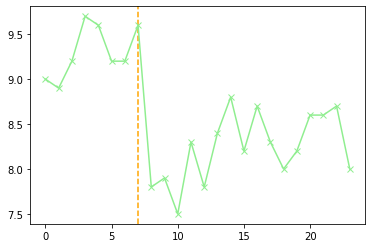

In [15]:
plot_data(tid='tt2356777')

#### 13 Reasons Why
<img src="../img/13reasonswhy.jpg" align="left" />

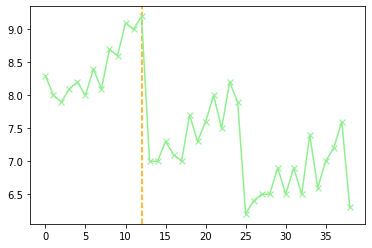

In [16]:
plot_data(tid='tt1837492')

In [17]:
series['trend'] = list(
    map(
        find_breakpoints, 
        series.averageRating
    )
)

In [18]:
series[series.trend.str.len() > 0].tail(5)

,parentTconst,averageRating,info,trend
21599,tt9886006,"[7.3, 8.0, 7.9, 7.6, 8.5, 7.5, 7.6, 7.9, 8.0, ...","[S1E1, S1E2, S1E3, S1E4, S1E5, S1E6, S1E7, S1E...",positive
21600,tt9886950,"[8.7, 8.4, 8.1, 8.1, 8.1, 7.8, 7.6, 7.6, 8.1, ...","[S1E1, S1E2, S1E3, S1E4, S1E5, S1E6, S1E7, S1E...",negative
21606,tt9899340,"[7.7, 7.7, 7.9, 8.2, 8.2, 8.2, 8.3, 8.3, 8.2, ...","[S1E1, S1E2, S1E3, S1E4, S1E5, S1E6, S1E7, S1E...",positive
21613,tt9909248,"[6.5, 7.5, 7.2, 6.9, 7.1, 7.1, 7.2, 6.7, 6.5, ...","[S1E0, S1E1, S1E2, S1E3, S1E4, S1E5, S1E6, S2E...",stable
21614,tt9910728,"[7.5, 7.2, 8.0, 8.7, 8.4, 8.4, 8.5, 8.1, 9.0, ...","[S1E1, S1E2, S1E3, S1E4, S1E5, S1E6, S1E7, S1E...",stable


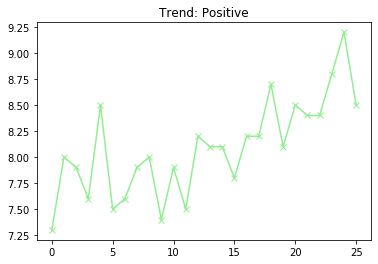

In [19]:
plot_data(tid='tt9886006')

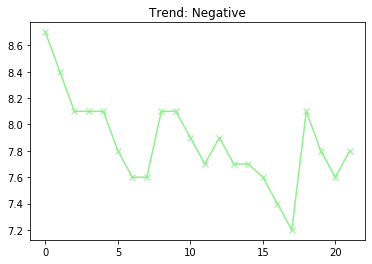

In [20]:
plot_data(tid='tt9886950')

In [21]:
c1 = series.trend.apply(lambda x: True if isinstance(x, list) else False)
c2 = series.trend.str.len() > 1
series[c1 & c2].tail(5)

,parentTconst,averageRating,info,trend
11787,tt1960255,"[6.9, 5.5, 5.8, 5.6, 5.6, 5.6, 3.6, 5.5, 5.5, ...","[S1E1, S1E2, S1E3, S1E4, S1E5, S1E6, S1E7, S1E...","[(91, negative), (170, positive)]"
14363,tt3281796,"[7.8, 7.8, 8.1, 8.2, 8.1, 8.1, 8.6, 8.9, 8.7, ...","[S1E1, S1E2, S1E3, S1E4, S1E5, S1E6, S1E7, S1E...","[(5, positive), (56, negative)]"
16686,tt5133998,"[6.8, 6.2, 6.1, 5.7, 5.8, 5.4, 5.7, 5.5, 5.2, ...","[S1E1, S1E2, S1E3, S1E4, S1E5, S1E6, S1E7, S1E...","[(4, negative), (68, positive)]"
19826,tt7834636,"[7.2, 7.8, 7.8, 7.8, 6.7, 7.4, 7.2, 7.4, 8.2, ...","[S1E1, S1E2, S1E3, S1E4, S1E5, S1E6, S1E7, S1E...","[(7, positive), (47, negative)]"
20704,tt8690890,"[8.3, 8.1, 8.4, 8.1, 8.4, 8.5, 8.6, 8.6, 8.8, ...","[S1E1, S1E2, S1E3, S1E4, S1E5, S1E6, S1E7, S1E...","[(5, positive), (43, negative)]"


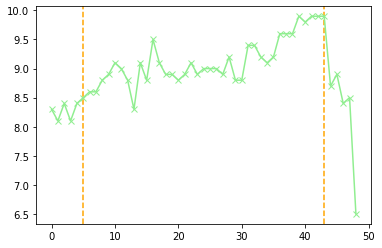

In [22]:
plot_data(tid='tt8690890')

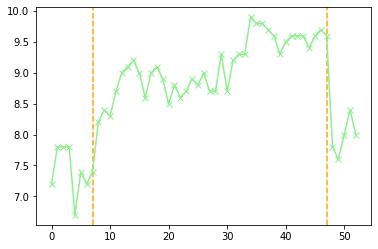

In [23]:
plot_data(tid='tt7834636')

In [24]:
def assign_cluster(info, trend):
    if isinstance(trend, str):
        return trend
    
    d = {
        'negative': 0,
        'positive': 0
    }
    last_index = 0
    c = len(info)

    for i, j in enumerate(trend):
        index, status = j
        not_status = 'positive' if status == 'negative' else 'negative'

        if i == 0:
            last_index = index

        d[not_status] += index - last_index
        if i == len(trend) - 1:
            d[status] += c - index

        last_index = index
    
    if d['positive'] / c > .5:
        return 'generally_positive'
    elif d['negative'] / c > .5:
        return 'generally_negative'
    
    return 'generally_stable'

In [25]:
series['cluster'] = list(
    map(
        assign_cluster, 
        series['info'],
        series['trend']
    )
)

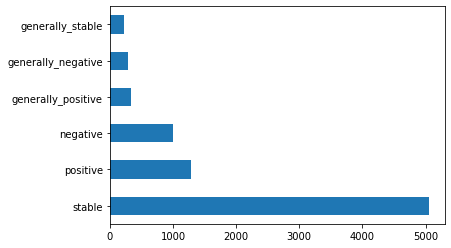

In [26]:
series.cluster.value_counts().plot(kind='barh');

In [27]:
series[series.cluster == 'generally_positive'].head(5)

,parentTconst,averageRating,info,trend,cluster
22,tt0042093,"[7.1, 6.7, 6.8, 6.5, 7.0, 6.6, 6.7, 7.0, 7.1, ...","[S1E1, S1E2, S1E3, S1E4, S1E5, S1E6, S1E7, S1E...","[(13, positive)]",generally_positive
29,tt0042111,"[7.9, 7.8, 7.4, 7.6, 8.1, 8.6, 8.5, 7.4, 7.3, ...","[S1E1, S1E2, S1E3, S1E4, S1E5, S1E7, S1E8, S1E...","[(4, positive)]",generally_positive
93,tt0045409,"[6.9, 7.2, 7.2, 7.1, 7.6, 7.5, 7.6, 7.7, 6.4, ...","[S1E1, S1E2, S1E3, S1E4, S1E5, S1E6, S1E7, S1E...","[(4, positive)]",generally_positive
476,tt0058796,"[7.5, 5.2, 6.0, 4.8, 4.0, 4.8, 3.6, 5.1, 4.3, ...","[S1E1, S1E2, S1E3, S1E4, S1E5, S1E6, S1E7, S1E...","[(50, positive)]",generally_positive
711,tt0065317,"[6.2, 6.8, 6.4, 6.4, 6.5, 6.8, 6.9, 7.0, 7.3, ...","[S1E0, S1E1, S1E2, S1E3, S1E4, S1E5, S1E6, S2E...","[(4, positive)]",generally_positive


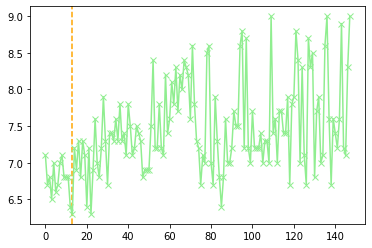

In [28]:
plot_data('tt0042093')

In [29]:
series[series.cluster == 'generally_negative'].head(5)

,parentTconst,averageRating,info,trend,cluster
241,tt0051247,"[8.6, 8.3, 8.0, 8.2, 8.4, 8.5, 8.6, 8.4, 7.5, ...","[S1E1, S1E2, S1E3, S1E4, S1E5, S1E6, S1E7, S1E...","[(7, negative)]",generally_negative
289,tt0052472,"[8.5, 8.1, 8.1, 7.4, 7.8, 8.0, 8.0, 8.2, 8.0, ...","[S1E1, S1E2, S1E3, S1E4, S1E5, S1E6, S1E7, S1E...","[(8, negative)]",generally_negative
306,tt0052506,"[7.1, 7.4, 7.5, 7.5, 7.4, 7.6, 5.9, 7.1, 7.0, ...","[S1E1, S1E2, S1E3, S1E4, S1E5, S1E6, S1E7, S1E...","[(5, negative)]",generally_negative
307,tt0052507,"[7.8, 8.0, 7.8, 7.9, 7.7, 7.9, 8.2, 8.0, 8.1, ...","[S1E1, S1E2, S1E3, S1E4, S1E5, S1E6, S1E7, S1E...","[(47, negative)]",generally_negative
384,tt0055662,"[8.1, 7.9, 7.9, 8.0, 8.0, 7.9, 7.9, 7.8, 8.0, ...","[S1E1, S1E2, S1E3, S1E4, S1E5, S1E6, S1E7, S1E...","[(4, negative)]",generally_negative


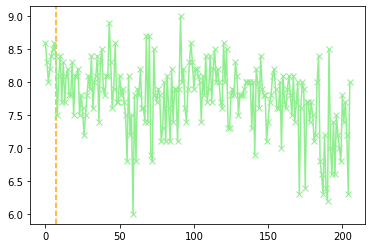

In [30]:
plot_data('tt0051247')